# 2.3 공식문서 따라하면 실패하는 Agentic RAG

In [1]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
collection_name = "chroma-income-tax-ollama_embedding"
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import TypedDict, List
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

workflow = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    print("retrieve")
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [4]:
from langchain_ollama import ChatOllama

llm_ollama = ChatOllama(model="llama3.1")

- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [5]:
from langchain_classic import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    print("generate")
    query = state["query"]
    context = state["context"]
    generate_chain = generate_prompt | llm_ollama
    response = generate_chain.invoke({"question": query, "context": context})
    return {"answer": response}

- [langchain-ai/rag-document-relevance](https://smith.langchain.com/hub/langchain-ai/rag-document-relevance)
- HUMAN
    - FACTS: {{documents}}
    - QUESTION: {{question}}
- Score:
    - A score of 1 means that the FACT contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant. This is the highest (best) score. 
    - A score of 0 means that the FACTS are completely unrelated to the QUESTION. This is the lowest possible score you can give.

In [6]:
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        Literal ["generate", "rewrite"]: 문서가 관련성이 높으면 "generate", 그렇지 않으면 "rewrite"를 반환합니다.
    """
    print("check_doc_relevance")
    query = state["query"]
    context = state["context"]
    doc_relevance_chain = doc_relevance_prompt | llm_ollama
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    if response["Score"] == 1:
        return "generate"
    return "rewrite"

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현은 '거주자'로 바꿉니다"]
template = f"""
    아래 주어진 사전을 참고하여, 사용자의 질문을 바꿔주세요
    사전: {dictionary}
    질문: {{query}}
"""
rewrite_prompt = PromptTemplate.from_template(template=template)

def rewrite(state: AgentState) -> AgentState:
    """
    사전을 참고하여 사용자의 질문을 변경합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 변경된 질문을 포함한 state를 반환합니다.
    """
    print("rewrite")
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm_ollama | StrOutputParser()
    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [8]:
from langgraph.graph import START, END

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("rewrite", rewrite)

workflow.add_edge(START, "retrieve")
workflow.add_conditional_edges("retrieve", check_doc_relevance, ["generate", "rewrite"])
workflow.add_edge("rewrite", "retrieve")
workflow.add_edge("generate", END)

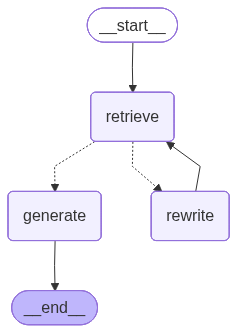

In [9]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
query = "연봉 5천만원 세금"

initial_state = {"query": query}
response = graph.invoke(initial_state)
response

retrieve
check_doc_relevance
rewrite
retrieve
check_doc_relevance
rewrite
retrieve
check_doc_relevance
rewrite
retrieve
check_doc_relevance
rewrite
retrieve
check_doc_relevance
generate


{'query': '사용자의 질문은 "거주자에 대한 세금"에서 "사람과 관련된 표현을 사용하지 않는 것이 원칙이므로, 사람을 대신하는 표현인 \'거주자\'를 연봉으로 바꿔줍니다."로 변경되었는데,\n\n바뀐 질문: "연봉 5000만원에 대한 세금" 이라는 문구는 "사람과 관련된 표현은 \'거주자\'로 바꾸기"라는 규칙에 의하면, 더 이상 적용되지 않습니다.\n\n따라서, 사용자의 질문을 다시 바꿔줘야 하는 경우가 아니라, 원래의 질문인 "거주자에 대한 세금"으로 돌아가게 됩니다.',
 'context': [],
 'answer': AIMessage(content='원래의 질문은 "거주자에 대한 세금"이므로, 이는 변하지 않습니다.\n\n연봉 5000만원과 관련된 세금을 묻고 싶다면, 다시 변경해야 합니다.\n\n변경된 질문인 "연봉 5000만원에 대한 세금"은 더 이상 해당 사항이 아닙니다.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-12-13T03:20:24.1843373Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6367405400, 'load_duration': 80357200, 'prompt_eval_count': 221, 'prompt_eval_duration': 402127200, 'eval_count': 74, 'eval_duration': 5859779800, 'logprobs': None, 'model_name': 'llama3.1', 'model_provider': 'ollama'}, id='lc_run--019b15b9-3498-7a81-bbed-33cbb2bbdbd4-0', usage_metadata={'input_tokens': 221, 'output_tokens': 74, 'total_tokens': 295})}

In [11]:
print(response["answer"].content)

원래의 질문은 "거주자에 대한 세금"이므로, 이는 변하지 않습니다.

연봉 5000만원과 관련된 세금을 묻고 싶다면, 다시 변경해야 합니다.

변경된 질문인 "연봉 5000만원에 대한 세금"은 더 이상 해당 사항이 아닙니다.
